## Load and Preprocess Data
`emg.csv: timestamp, emg_channel_1, emg_channel_2, emg_channel_3, emg_channel_4, emg_channel_5, emg_channel_6, emg_channel_7, emg_channel_8`

`finger_angles.csv: timestamp, THUMB, INDEX, MIDDLE, RING, PINKY`

In [1]:
import os
import pandas as pd
import re
import json
from exg.ema import EMA
from exg.sma import SMA
from exg.iir import IIR

In [ ]:
def load_data(session_dir: str,
              finger_columns: list[str],
              window_sizes: list[int],
              exg_fs: int):
    """
    Load & process one session directory containing:
      - exg.csv      (timestamp + raw EMG channels)
      - prompt.csv   (timestamp + finger columns)
    """
    # Read CSVs
    exg_path    = os.path.join(session_dir, "exg.csv")
    prompt_path = os.path.join(session_dir, "prompt.csv")
    exg_data    = pd.read_csv(exg_path)
    angle_data  = pd.read_csv(prompt_path)

    # Infer column sets
    raw_columns    = [c for c in exg_data.columns   if c != "timestamp"]
    # only pick the finger columns you care about:
    angle_columns  = [c for c in finger_columns    if c in angle_data.columns]

    # Timestamps to timedelta
    exg_data['timestamp']   = pd.to_timedelta(exg_data["timestamp"], unit='ms')
    angle_data['timestamp'] = pd.to_timedelta(angle_data["timestamp"], unit='ms')

    # Apply filters
    iir_proc = IIR(
        num_channels=len(raw_columns),
        fs=exg_fs,
        lowpass_fs=exg_fs/2,
        highpass_fs=10,
        notch_fs_list=[50, 60],
        filter_order=4
    )
    filtered = iir_proc.process(exg_data[raw_columns].values)
    exg_data[raw_columns] = filtered

    # Apply smoothing methods
    ema_proc = EMA(window_sizes=window_sizes,
                   num_channels=len(raw_columns),
                   fs=exg_fs)
    sma_proc = SMA(window_sizes=window_sizes,
                   num_channels=len(raw_columns),
                   fs=exg_fs)

    ema_vals = ema_proc.process(filtered)
    ema_df   = ema_proc.results_to_df(ema_vals)

    sma_vals = sma_proc.process(filtered)
    sma_df   = sma_proc.results_to_df(sma_vals)

    # Add all columns to exg_data
    processed_exg = pd.concat([exg_data, ema_df, sma_df], axis=1)

    # Shift timestamps to allow user to transition after the prompt
    transition_ms = 2000
    angle_data['timestamp'] += pd.Timedelta(milliseconds=transition_ms)
    tolerance_ms = 5000 - transition_ms

    merged = pd.merge_asof(
        processed_exg.sort_values('timestamp'),
        angle_data[angle_columns + ["timestamp"]].sort_values('timestamp'),
        on="timestamp",
        direction='backward',
        tolerance=pd.Timedelta(milliseconds=tolerance_ms)
    ).set_index("timestamp")
    merged = merged.dropna()

    return merged, raw_columns, ema_df.columns.tolist(), sma_df.columns.tolist(), sma_proc.window_intervals_ms


def load_session(session_folder: str,
                 finger_columns: list[str],
                 window_sizes: list[int]):
    """
    Discover all r_<n> subfolders in session_folder, load & process each.
    Returns:
      - sessions: list of DataFrames
      - ema_columns, sma_columns, window_intervals_ms (from last session)
    """
    # Check if session_folder exists
    if not os.path.exists(session_folder):
        raise FileNotFoundError(f"Session folder {session_folder} does not exist.")
    
    # Check if frequency_info.json exists
    freq_info_path = os.path.join(session_folder, "frequency_info.json")
    if not os.path.exists(freq_info_path):
        raise FileNotFoundError(f"frequency_info.json not found in {session_folder}.")
    
    with open(freq_info_path, 'r') as f:
        freq_info = json.load(f)
    exg_fs = freq_info.get("exg_fs")
    if exg_fs is None:
        raise ValueError("exg_fs not found in frequency_info.json.")
    
    # find all r_<n> dirs
    dirs = [
        d for d in os.listdir(session_folder)
        if os.path.isdir(os.path.join(session_folder, d))
           and re.match(r"^r_(\d+)$", d)
    ]
    # sort by the numeric idx
    dirs.sort(key=lambda d: int(d.split("_", 1)[1]))

    sessions = []
    ema_cols = sma_cols = None
    window_ints = None
    
    for d in dirs:
        full_path = os.path.join(session_folder, d)
        print(f"Loading session {d} …")
                 
        # Load & process the data
        df, raw_cols, ema_cols, sma_cols, window_ints = load_data(
            session_dir    = full_path,
            finger_columns = finger_columns,
            window_sizes   = window_sizes,
            exg_fs         = exg_fs
        )
        sessions.append(df)

    return sessions, exg_fs, raw_cols, ema_cols, sma_cols, window_ints

# Set parameters
window_sizes   = [128]
finger_columns = ["thumb", "index", "middle", "pinky"]
session_folder = "../data/s_04_29_25"    # contains r_0/, r_1/, …

sessions, exg_fs, exg_cols, ema_cols, sma_cols, window_intervals = load_session(
    session_folder,
    finger_columns,
    window_sizes,
)

# sessions is now a list of one DataFrame per r_<n> folder
for i, df in enumerate(sessions):
    print(f"Session {i}: {df.shape[0]} rows, columns = {list(df.columns)}")

Loading session r_0 …
Loading session r_1 …
Loading session r_2 …
Loading session r_3 …
Loading session r_4 …
Loading session r_5 …
Loading session r_6 …
Loading session r_7 …
Loading session r_8 …
Loading session r_9 …
Session 0: 18010 rows, columns = ['exg_1', 'exg_2', 'exg_3', 'exg_4', 'exg_5', 'exg_6', 'exg_7', 'exg_8', 'ch_1_ema_mean_512ms', 'ch_2_ema_mean_512ms', 'ch_3_ema_mean_512ms', 'ch_4_ema_mean_512ms', 'ch_5_ema_mean_512ms', 'ch_6_ema_mean_512ms', 'ch_7_ema_mean_512ms', 'ch_8_ema_mean_512ms', 'ch_1_ema_mean_square_512ms', 'ch_2_ema_mean_square_512ms', 'ch_3_ema_mean_square_512ms', 'ch_4_ema_mean_square_512ms', 'ch_5_ema_mean_square_512ms', 'ch_6_ema_mean_square_512ms', 'ch_7_ema_mean_square_512ms', 'ch_8_ema_mean_square_512ms', 'ch_1_ema_root_mean_square_512ms', 'ch_2_ema_root_mean_square_512ms', 'ch_3_ema_root_mean_square_512ms', 'ch_4_ema_root_mean_square_512ms', 'ch_5_ema_root_mean_square_512ms', 'ch_6_ema_root_mean_square_512ms', 'ch_7_ema_root_mean_square_512ms', 'ch_8

In [3]:
# Print the Average Value and Standard Deviation for the first data session
def print_stats(data):
    """Prints the average and standard deviation of the data."""
    for column in data.columns:
        print(f"{column}: (MEAN: {data[column].mean()}, STD: {data[column].std()})")
        
print_stats(sessions[0])

exg_1: (MEAN: -0.009872826235646963, STD: 20.698361436621397)
exg_2: (MEAN: -0.011540694184537884, STD: 9.567450606103092)
exg_3: (MEAN: 0.0027734916226141064, STD: 8.018555345550057)
exg_4: (MEAN: -0.0139553853402412, STD: 14.859252613709558)
exg_5: (MEAN: -0.015278149538189826, STD: 12.016378476892253)
exg_6: (MEAN: -0.012158744971619787, STD: 9.293404710965284)
exg_7: (MEAN: -0.0006568373392194464, STD: 10.62085543459355)
exg_8: (MEAN: 0.00360320438434302, STD: 7.882725672196691)
ch_1_ema_mean_512ms: (MEAN: 14.867452152201926, STD: 7.965222074038096)
ch_2_ema_mean_512ms: (MEAN: 7.221017890967015, STD: 3.1533554478747243)
ch_3_ema_mean_512ms: (MEAN: 5.905195771598437, STD: 2.969754018570807)
ch_4_ema_mean_512ms: (MEAN: 10.79421869074931, STD: 5.767254747983548)
ch_5_ema_mean_512ms: (MEAN: 8.547332232171966, STD: 5.007607239987997)
ch_6_ema_mean_512ms: (MEAN: 6.8012251491294275, STD: 3.785297271114992)
ch_7_ema_mean_512ms: (MEAN: 8.35630327665987, STD: 2.885881030140576)
ch_8_ema_mean

### Graphing

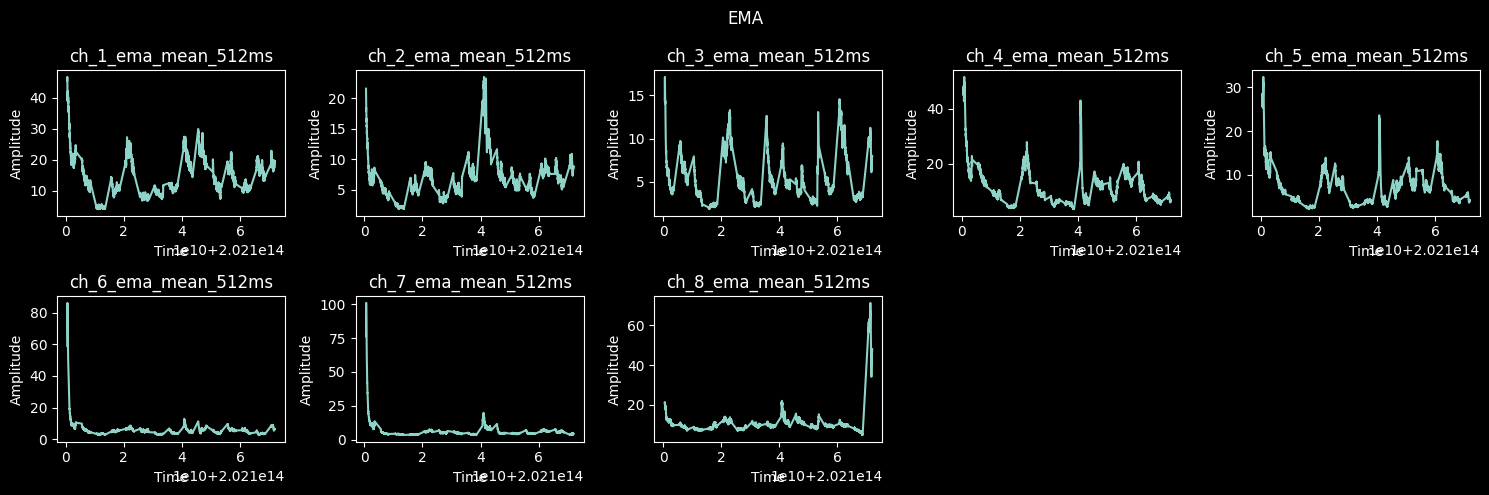

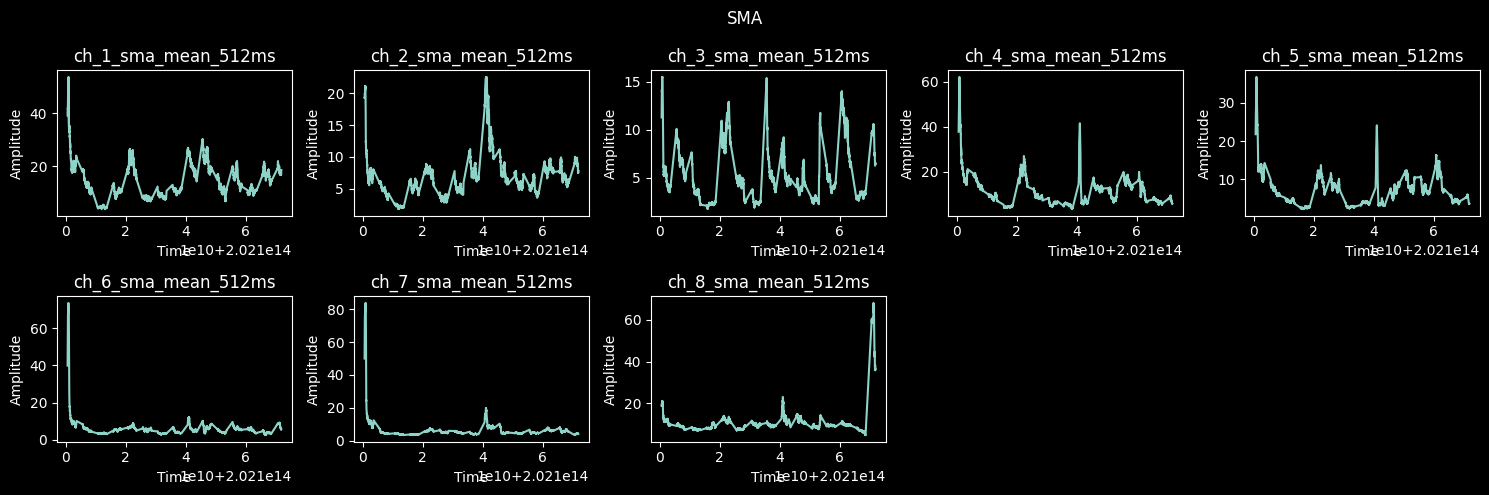

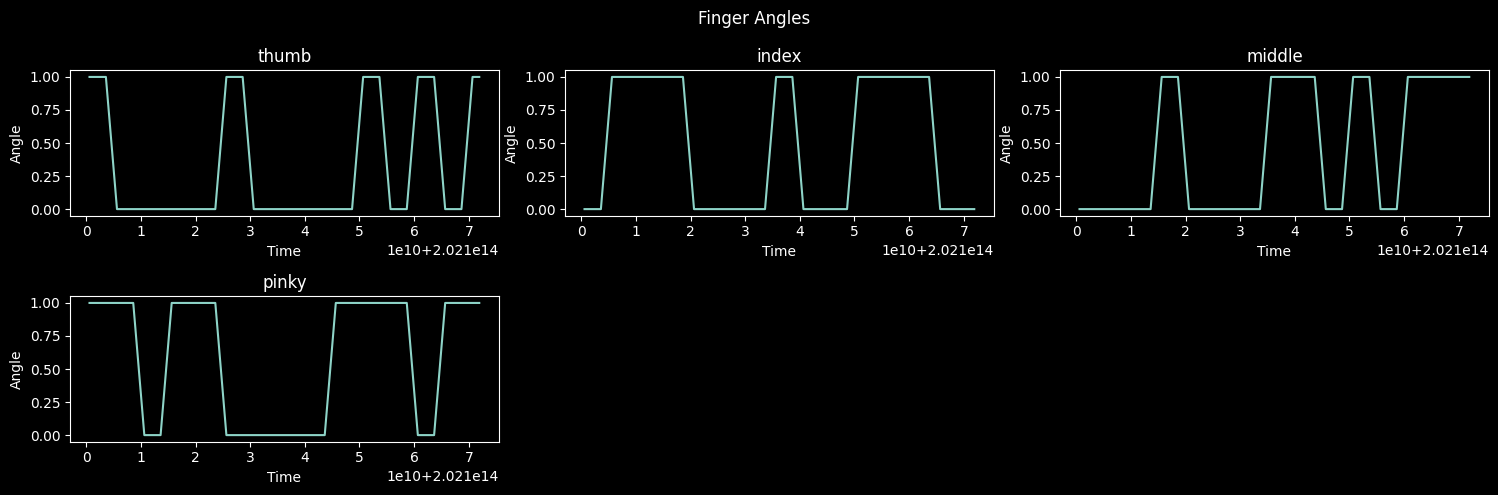

In [4]:
import matplotlib.pyplot as plt

def graph_emg_channel(emg_channel, title="EMG Channel"):
    """Graphs a single EMG channel."""
    plt.figure(figsize=(15, 5))
    plt.plot(emg_channel.abs())
    plt.title(title)
    plt.xlabel("Time")
    plt.ylabel("Amplitude")
    plt.show()
    
def graph_emg(emg_data, emg_columns=None, title="EMG"):
    """Graphs the EMG data for all channels in a 2x4 grid."""
    # If no columns are specified, use all columns except the timestamp
    if emg_columns is None:
        emg_columns = emg_data.columns
    
    # Plot a 2 x 4 grid of EMG data
    plt.figure(figsize=(15, 5))
    plt.suptitle(title)
    for i, channel_name in enumerate(emg_columns):
        plt.subplot(2, 5, i + 1)
        plt.plot(emg_data[channel_name], label=f"{channel_name}")
        plt.title(f"{channel_name}")
        plt.xlabel("Time")
        plt.ylabel("Amplitude")
    plt.tight_layout()
    plt.show()

def graph_finger(finger_data, finger_channels=None, title="Finger Angles"):
    """Graphs the finger angle data for all fingers in a 2x3 grid."""
    # If no columns are specified, use all columns except the timestamp
    if finger_channels is None:
        finger_channels = finger_data.columns
    
    # Plot a 2 x 3 grid of finger data
    plt.figure(figsize=(15, 5))
    plt.suptitle(title)
    for i, finger_name in enumerate(finger_channels):
        plt.subplot(2, 3, i + 1)
        plt.plot(finger_data[finger_name], label=f"{finger_name}")
        plt.title(f"{finger_name}")
        plt.xlabel("Time")
        plt.ylabel("Angle")
    plt.tight_layout()
    plt.show()

# Graph the first subsession
graph_emg(sessions[-1][ema_cols[:8]], title="EMA")
graph_emg(sessions[-1][sma_cols[:8]], title="SMA")
graph_finger(sessions[-1][finger_columns], title="Finger Angles")

In [5]:
def drop_nan_sessions(session):
    """Drops NaN values from all data in a session."""
    return [data.dropna() for data in session]

# Drop NaN values from the session
preprocessed = drop_nan_sessions(sessions)
# Print the number of samples before and after dropping NaN values
for i, data in enumerate(sessions):
    print(f"Samples before dropping NaN for session {i}: {len(data)}")
    print(f"Samples after dropping NaN for session {i}: {len(preprocessed[i])}")

Samples before dropping NaN for session 0: 18010
Samples after dropping NaN for session 0: 18010
Samples before dropping NaN for session 1: 9658
Samples after dropping NaN for session 1: 9658
Samples before dropping NaN for session 2: 18161
Samples after dropping NaN for session 2: 18161
Samples before dropping NaN for session 3: 12307
Samples after dropping NaN for session 3: 12307
Samples before dropping NaN for session 4: 24032
Samples after dropping NaN for session 4: 24032
Samples before dropping NaN for session 5: 27756
Samples after dropping NaN for session 5: 27756
Samples before dropping NaN for session 6: 22635
Samples after dropping NaN for session 6: 22635
Samples before dropping NaN for session 7: 13258
Samples after dropping NaN for session 7: 13258
Samples before dropping NaN for session 8: 24644
Samples after dropping NaN for session 8: 24644
Samples before dropping NaN for session 9: 10818
Samples after dropping NaN for session 9: 10818


## Train/Validation/Test Splits

In [30]:
import numpy as np

# Split the data into training, validation, and test sets
x_cols = [ema_cols[i] for i in [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]] 
# x_columns = ema_cols
num_sessions = len(preprocessed)
preprocessed_range = list(range(0, num_sessions))
val_sessions = preprocessed_range[-1:]
# Set to the difference of the preprocessed range and the validation sessions
train_sessions = list(set(preprocessed_range) - set(val_sessions))

delay = 4 # Delay in frames

X_train = []
y_train = []
for session_idx in train_sessions:
    emg = preprocessed[session_idx][x_cols]
    finger = preprocessed[session_idx][finger_columns]
    X_train.append(emg[:emg.shape[0]-delay])
    y_train.append(finger[delay:])

X_val = []
y_val = []
for session_idx in val_sessions:
    emg = preprocessed[session_idx][x_cols]
    finger = preprocessed[session_idx][finger_columns]
    X_val.append(emg[:emg.shape[0]-delay])
    y_val.append(finger[delay:])
    
X_val_no_delay = []
y_val_no_delay = []
for session_idx in val_sessions:
    emg = preprocessed[session_idx][x_cols]
    finger = preprocessed[session_idx][finger_columns]
    X_val_no_delay.append(emg)
    y_val_no_delay.append(finger)
    
# Combine the training and validation sets
X_train = np.concatenate(X_train)
X_val = np.concatenate(X_val)
y_train = np.concatenate(y_train)
y_val = np.concatenate(y_val)
X_val_no_delay = np.concatenate(X_val_no_delay)
y_val_no_delay = np.concatenate(y_val_no_delay)

# Mean and standard deviation for each channel
train_mean = X_train.mean(axis=0)
train_std = X_train.std(axis=0)

# Normalize the data
# X_train = (X_train - train_mean) / train_std
# X_val = (X_val - train_mean) / train_std
# X_val_no_delay = (X_val_no_delay - train_mean) / train_std
X_train = X_train / train_std
X_val = X_val / train_std
X_val_no_delay = X_val_no_delay / train_std

# Print the shapes of the training and validation sets
print(f"X_train shape: {X_train.shape}, Y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}, Y_val shape: {y_val.shape}")

X_train shape: (170425, 16), Y_train shape: (170425, 4)
X_val shape: (10814, 16), Y_val shape: (10814, 4)


### MLP Model

In [31]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GaussianNoise, Input, BatchNormalization

def create_model(input_shape, output_shape, gaussian_noise=0.1, loss='mse', metrics=['r2_score', 'binary_accuracy']):
    model = Sequential([
        Input(shape=input_shape),
        GaussianNoise(gaussian_noise),
        # Dense(128, activation='relu'),
        # BatchNormalization(),
        # Dropout(0.3),
        Dense(64, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),
        Dense(32, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),
        Dense(output_shape, activation='sigmoid')
    ])
    
    model.compile(optimizer='adam', loss=loss, metrics=metrics)
    return model

def train_model(model, X_train, y_train, X_val, y_val, patience=10, epochs=200, batch_size=1024):
    # Define callbacks
    early_stopping = EarlyStopping(monitor='val_r2_score', 
                                   patience=patience, 
                                   restore_best_weights=True,
                                   mode='max')
                                   
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
                                  factor=0.5, 
                                  patience=5, 
                                  verbose=1,
                                  mode='min'
                                  )
    
    # Train the model
    history = model.fit(X_train, y_train, 
                        epochs=epochs, 
                        validation_data=(X_val, y_val), 
                        batch_size=batch_size, 
                        callbacks=[early_stopping, reduce_lr],
                        verbose=1)
    
    return model, history

def create_and_train_model(X_train, y_train, X_val, y_val, gaussian_noise=0.01,
                           patience=10, epochs=200, batch_size=1024,
                           loss='BinaryCrossentropy', metrics=['r2_score', 'binary_accuracy']):
    # Create the model
    # if loss == 'categorical_crossentropy':
    #     y_train = np.round(y_train)
    #     y_val = np.round(y_val)
    input_shape = (X_train.shape[1],)
    output_shape = y_train.shape[1]

    model = create_model(input_shape=input_shape, 
                         output_shape=output_shape, 
                         gaussian_noise=gaussian_noise,
                         loss=loss,
                         metrics=metrics)
    
    return train_model(model, X_train, y_train, X_val, y_val, 
                       patience=patience, epochs=epochs, batch_size=batch_size)

In [32]:
model, history = create_and_train_model(X_train, y_train, X_val, y_val)

Epoch 1/200
167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - binary_accuracy: 0.6922 - loss: 0.6023 - r2_score: 0.2012 - val_binary_accuracy: 0.8730 - val_loss: 0.4183 - val_r2_score: 0.4942 - learning_rate: 0.0010
Epoch 2/200
167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - binary_accuracy: 0.8857 - loss: 0.2876 - r2_score: 0.6576 - val_binary_accuracy: 0.8796 - val_loss: 0.4187 - val_r2_score: 0.5881 - learning_rate: 0.0010
Epoch 3/200
167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - binary_accuracy: 0.9131 - loss: 0.2250 - r2_score: 0.7378 - val_binary_accuracy: 0.8833 - val_loss: 0.5935 - val_r2_score: 0.6133 - learning_rate: 0.0010
Epoch 4/200
167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - binary_accuracy: 0.9263 - loss: 0.1964 - r2_score: 0.7750 - val_binary_accuracy: 0.8709 - val_loss: 0.7472 - val_r2_score: 0.5969 - learning_rate: 0.0010
Epoch 5/200
167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - binary_accuracy: 0.9348 - loss: 0.1765 - r2_score: 0.8005 - val_binary_accuracy: 0.8829 - val_loss: 0.8489 - 

In [33]:
from math import sqrt
from sklearn.metrics import r2_score

# Evaluate on the validation set
val_loss, val_r2, val_b_acc = model.evaluate(X_val, y_val, verbose=0)
y_pred = model.predict(X_val)

print(f"Validation Loss: {val_loss}")
if val_r2 > 0:
    print(f"Validation R Score: {sqrt(val_r2)}")
print(f"Validation R2 Score: {val_r2}")
print(f"Validation Binary Accuracy: {val_b_acc}")
# Calculate and print the correlation coefficient for each finger
for i, finger in enumerate(finger_columns):
    r2 = r2_score(y_val[:, i], y_pred[:, i])
    if r2 < 0:
        r2 = 0
    print(f"R score for {finger}: {sqrt(r2)}")

338/338 ━━━━━━━━━━━━━━━━━━━━ 0s 393us/step
Validation Loss: 0.9315918684005737
Validation R Score: 0.7908393192433192
Validation R2 Score: 0.6254268288612366
Validation Binary Accuracy: 0.885495662689209
R score for thumb: 0.9373997075587273
R score for index: 0.7084550603893299
R score for middle: 0.793510615648259
R score for pinky: 0.7010145255866963


#### Save model

In [34]:
def extract_method_interval_xcols(xma:str="ema"):
    """Extracts the channel name from the column name."""
    xma_methods = set()
    xma_intervals = set()
    for col in x_cols:
        if xma in col:
            split = col.split("_")
            method = split[3:-1]
            method = "_".join(method)
            interval = int(split[-1][:-2])
            
            xma_methods.add(method)
            xma_intervals.add(interval)
    xma_methods = sorted(list(xma_methods))
    xma_intervals = sorted(list(xma_intervals))
    # ema_intervals: [512]
    return xma_methods, xma_intervals

In [36]:
def save_model():
    model_dir = session_folder + "/models/model_0"

    # Create the models directory if it does not exist
    if not os.path.exists(model_dir):
        os.makedirs(model_dir)
    model.save(f"{model_dir}/model.keras")

    # Extract the methods and intervals for EMA and SMA
    ema_methods, ema_intervals = extract_method_interval_xcols(xma="ema")
    sma_methods, sma_intervals = extract_method_interval_xcols(xma="sma")
    # Save the model parameters to a JSON file
    model_params = {
        "finger_columns": finger_columns,
        "x_cols": x_cols,
        "exg_fs": exg_fs,
        "ema_methods": ema_methods,
        "ema_intervals": ema_intervals,
        "sma_methods": sma_methods,
        "sma_intervals": sma_intervals,
        "train_mean": train_mean.tolist(),
        "train_std": train_std.tolist(),
    }
    with open(f"{model_dir}/model_params.json", 'w') as f:
        json.dump(model_params, f, indent=4)

# Save the model
save_model()

### Determine which are the best 8 (or n) Channels
Takes very long to run, only run if you want to determine the most important n important channels, such as to reduce the number of channels.

In [ ]:
%pip install tqdm

In [ ]:
import numpy as np
from itertools import combinations
from tqdm import tqdm

def evaluate_subset(ch_idx, X_train_full, y_train, X_val_full, y_val,
                    gaussian_noise=0.01, patience=10, epochs=200, batch_size=1024):
    """
    Train on only the columns in ch_idx, return the best val_r2_score.
    """
    X_tr = X_train_full[:, ch_idx]
    X_vl = X_val_full[:, ch_idx]
    
    # re-train model from scratch
    model, history = create_and_train_model(
        X_tr, y_train, X_vl, y_val,
        gaussian_noise=gaussian_noise,
        patience=patience,
        epochs=epochs,
        batch_size=batch_size,
        loss='BinaryCrossentropy',
        metrics=['r2_score','binary_accuracy']
    )
    # get max val_r2_score achieved
    return max(history.history['val_r2_score'])

def select_best_channels_greedy(channel_indices, X_train_full, y_train,
                                 X_val_full, y_val, n_channels, **eval_kwargs):
    """
    Greedy forward selection: start empty, add one channel at a time.
    
    Args:
      channel_indices: list of ints [0,1,2,…,C-1]
      X_*: 2D arrays (samples × channels)
      y_*: labels
      n_channels: how many to pick
      eval_kwargs: passed to evaluate_subset
    
    Returns:
      selected: list of channel indices (length n_channels)
      scores: list of val_r2 after each addition
    """
    remaining = set(channel_indices)
    selected = []
    scores = []
    
    for k in tqdm(range(n_channels), desc="Selecting channels"):
        best_chan, best_score = None, -np.inf
        for c in remaining:
            trial = selected + [c]
            score = evaluate_subset(trial, X_train_full, y_train,
                                    X_val_full, y_val, **eval_kwargs)
            if score > best_score:
                best_score, best_chan = score, c
        selected.append(best_chan)
        remaining.remove(best_chan)
        scores.append(best_score)
        print(f"Picked channel {best_chan} → val_r2={best_score:.4f}")
    return selected, scores

# — example usage —
# suppose X_train (N×16), X_val (M×16), y_train (N×D), y_val (M×D):
all_ch = list(range(X_train.shape[1]))
best8, perf8 = select_best_channels_greedy(
    all_ch, X_train, y_train, X_val, y_val,
    n_channels=8,
    gaussian_noise=0.01,
    patience=5,   # fewer epochs for speed, tweak as you like
    epochs=100,
    batch_size=512
)

print("Best 8 channels:", best8)


### Visualize Model Results on Validation Data

In [ ]:
import pandas as pd

y_pred = (model.predict(X_val_no_delay) > 0.5) * 1
y_test_df = pd.DataFrame(y_val_no_delay, columns=finger_columns)
y_pred_df = pd.DataFrame(y_pred, columns=finger_columns)

In [ ]:
import plotly.graph_objs as go
from plotly.subplots import make_subplots
from IPython.display import display
import plotly.io as pio

def create_plotly_animation(
    y_true, 
    y_pred, 
    finger_names, 
    window_size=250*5, 
    step_size=10, 
    fps=10, 
    max_fingers=5,
    external_window=False
):
    """
    Creates an efficient animated Plotly figure with multiple subplots, each representing a finger.
    
    Parameters:
    - y_true: pandas DataFrame containing actual target values.
    - y_pred: pandas DataFrame containing predicted target values.
    - finger_names: List of finger names (columns in DataFrame).
    - window_size: Number of samples to display per frame.
    - step_size: Number of samples to move forward in each frame.
    - fps: Frames per second for the animation.
    - max_fingers: Maximum number of fingers (subplots) to plot simultaneously.
    - external_window: If True, opens the animation in a separate browser window.
    
    Returns:
    - Plotly Figure object.
    """
    # Limit the number of fingers to plot for efficiency
    if len(finger_names) > max_fingers:
        print(f"Limiting to first {max_fingers} fingers for performance.")
        finger_names = finger_names[:max_fingers]
        y_true = y_true[finger_names]
        y_pred = y_pred[finger_names]
    
    num_fingers = len(finger_names)
    num_samples = len(y_true)
    
    # Calculate the number of frames
    frames_indices = list(range(0, num_samples - window_size + step_size, step_size))
    if not frames_indices:
        frames_indices = [0]
    
    # Create subplots: one row per finger
    fig = make_subplots(
        rows=num_fingers, 
        cols=1, 
        shared_xaxes=True,
        subplot_titles=finger_names,
        vertical_spacing=0.05
    )
    
    # Initialize traces for each finger
    for i, finger in enumerate(finger_names, start=1):
        # Actual values
        fig.add_trace(
            go.Scatter(
                x=[], 
                y=[],
                mode='lines',
                line=dict(color='blue'),
                name=f'{finger} - Actual',
                showlegend=(i == 1)  # Show legend only for the first subplot
            ),
            row=i, 
            col=1
        )
        # Predicted values
        fig.add_trace(
            go.Scatter(
                x=[], 
                y=[],
                mode='lines',
                line=dict(color='red', dash='dash'),
                name=f'{finger} - Predicted',
                showlegend=(i == 1)  # Show legend only for the first subplot
            ),
            row=i, 
            col=1
        )
        
        # Fix the y-axis range between 0 and 1
        fig.update_yaxes(range=[-0.05, 1.05], row=i, col=1)
    
    # Generate frames
    frames = []
    for start in frames_indices:
        end = start + window_size
        if end > num_samples:
            end = num_samples
            start = max(end - window_size, 0)
        frame_data = []
        x_range = list(range(end - start))
        for i, finger in enumerate(finger_names):
            # Actual data
            actual = y_true.iloc[start:end, i].values
            # Predicted data
            pred = y_pred.iloc[start:end, i].values
            # Append updated traces
            frame_data.append(go.Scatter(x=x_range, y=actual))
            frame_data.append(go.Scatter(x=x_range, y=pred))
        frames.append(go.Frame(data=frame_data, name=str(start)))
    
    fig.frames = frames
    
    # Add play and pause buttons
    fig.update_layout(
        updatemenus=[
            dict(
                type='buttons',
                showactive=False,
                y=1,
                x=1.05,
                xanchor='right',
                yanchor='top',
                pad=dict(t=0, r=10),
                buttons=[
                    dict(
                        label='Play',
                        method='animate',
                        args=[
                            None,
                            dict(
                                frame=dict(duration=1000/fps, redraw=True),
                                transition=dict(duration=0),
                                fromcurrent=True,
                                mode='immediate'
                            )
                        ]
                    ),
                    dict(
                        label='Pause',
                        method='animate',
                        args=[
                            [None],
                            dict(
                                frame=dict(duration=0, redraw=False),
                                transition=dict(duration=0),
                                mode='immediate'
                            )
                        ]
                    )
                ]
            )
        ],
        sliders=[
            dict(
                active=0,
                currentvalue=dict(prefix='Start Index: '),
                pad=dict(t=50, b=10),
                steps=[
                    dict(
                        method='animate',
                        args=[
                            [str(start)],
                            dict(
                                frame=dict(duration=1000/fps, redraw=True),
                                transition=dict(duration=0),
                                mode='immediate'
                            )
                        ],
                        label=str(start)
                    ) for start in frames_indices
                ]
            )
        ],
        height=300*num_fingers, 
        width=900, 
        showlegend=True,
        title='Real-Time Animation of Predictions vs Actual Values'
    )
    
    # Set initial data
    if frames:
        initial_start = frames_indices[0]
        initial_end = initial_start + window_size
        if initial_end > num_samples:
            initial_end = num_samples
            initial_start = max(initial_end - window_size, 0)
        x_initial = list(range(initial_end - initial_start))
        for i, finger in enumerate(finger_names):
            actual = y_true.iloc[initial_start:initial_end, i].values
            pred = y_pred.iloc[initial_start:initial_end, i].values
            fig['data'][2*i].x = x_initial
            fig['data'][2*i].y = actual
            fig['data'][2*i+1].x = x_initial
            fig['data'][2*i+1].y = pred
    
    # Display the figure
    if external_window:
        # Use 'browser' renderer to open the animation in a separate browser window
        pio.renderers.default = 'browser'
    else:
        # Use the default renderer (typically inline in Jupyter)
        pio.renderers.default = 'notebook'
    
    return fig


# Define parameters
window_size = 100    # Number of samples per frame
step_size = int(250 * 1/10)       # Step size for each frame
fps = 10             # Frames per second
max_fingers = 5      # Adjust based on your system's capability

# Create the Plotly animation
plotly_fig = create_plotly_animation(
    y_true=y_test_df, 
    y_pred=y_pred_df, 
    finger_names=finger_columns, 
    window_size=window_size, 
    step_size=step_size, 
    fps=fps, 
    max_fingers=max_fingers
)

# Display the figure in Jupyter Notebook
plotly_fig.show()

### MAV, WL, WA, and VAR

In [ ]:
# %%
import pandas as pd
import numpy as np

def compute_MAV(signal_window):
    """Mean of the Absolute Value"""
    return np.mean(np.abs(signal_window))

def compute_WL(signal_window):
    """Waveform Length"""
    return np.sum(np.abs(np.diff(signal_window)))

def compute_WA(signal_window, threshold=0.02):
    """Willison Amplitude (count of threshold crossings)"""
    return np.sum(np.abs(signal_window) > threshold)

def compute_VAR(signal_window):
    """Variance"""
    return np.var(signal_window)

## CNN Model

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, BatchNormalization, Layer, GaussianNoise, Conv1D, Flatten, MaxPool1D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import backend as K
from sklearn.metrics import r2_score
from math import sqrt

# -----------------------------
# Create Sequences from Data
# -----------------------------
def create_sequences(X, y, window_size=64, step_size=5):
    """
    Creates overlapping sequences from the data.

    Parameters:
    - X: np.ndarray, shape (num_samples, num_features)
    - y: np.ndarray, shape (num_samples, num_targets)
    - window_size: int, number of time steps per sequence
    - step_size: int, step size between sequences

    Returns:
    - X_seq: np.ndarray, shape (num_sequences, window_size, num_features)
    - y_seq: np.ndarray, shape (num_sequences, num_targets)
    """
    X_seq = []
    y_seq = []
    for start in range(0, len(X) - window_size, step_size):
        end = start + window_size
        X_seq.append(X[start:end])
        y_seq.append(y[end-1])  # Predicting the last target in the window
    return np.array(X_seq), np.array(y_seq)

def create_sequences_from_session(preprocessed, session_list, exg_columns, window_size=64, step_size=5):
    """
    Creates sequences from a given session.

    Parameters:
    - session: list of pd.DataFrame, each containing EMG and finger data
    - window_size: int, number of time steps per sequence
    - step_size: int, step size between sequences

    Returns:
    - X_seq: np.ndarray, shape (num_sequences, window_size, num_features)
    - y_seq: np.ndarray, shape (num_sequences, num_targets)
    """
    X = []
    y = []
    # include all raw exg channels
    for i in session_list:
        emg_data = preprocessed[i][exg_columns]
        finger_data = preprocessed[i][finger_columns]
        X.append(emg_data)
        y.append(finger_data)

    X = pd.concat(X)
    y = pd.concat(y)
    X = X.values
    y = y.values
    
    # Mean and STD
    std = X.std(axis=0)
    X = X / std

    return create_sequences(X, y, window_size, step_size)

# Define window size and step size
WINDOW_SIZE = 64  # Adjust based on your data characteristics
STEP_SIZE = 1    # Adjust based on desired overlap

# Create sequences for training, validation, and test sets
X_train_seq, y_train_seq = create_sequences_from_session(preprocessed, train_sessions, exg_columns=exg_cols, window_size=WINDOW_SIZE, step_size=STEP_SIZE)
X_val_seq, y_val_seq = create_sequences_from_session(preprocessed, val_sessions, exg_columns=exg_cols, window_size=WINDOW_SIZE, step_size=STEP_SIZE)

print("Training sequences shape:", X_train_seq.shape, y_train_seq.shape)
print("Validation sequences shape:", X_val_seq.shape, y_val_seq.shape)

# -----------------------------
# Define Attention Layer
# -----------------------------

class AttentionLayer(Layer):
    """
    Custom Attention Layer.
    """
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)
    
    def build(self, input_shape):
        # input_shape: (batch_size, timesteps, features)
        self.W = self.add_weight(name='att_weight', 
                                 shape=(input_shape[-1], input_shape[-1]),
                                 initializer='random_normal', 
                                 trainable=True)
        self.b = self.add_weight(name='att_bias', 
                                 shape=(input_shape[-1],),  # Corrected shape
                                 initializer='zeros', 
                                 trainable=True)
        super(AttentionLayer, self).build(input_shape)
    
    def call(self, inputs):
        # Compute attention scores
        # scores shape: (batch_size, timesteps, features)
        scores = K.tanh(K.dot(inputs, self.W) + self.b)  # Shape: (batch_size, timesteps, features)
        attention_weights = K.softmax(scores, axis=1)    # Shape: (batch_size, timesteps, features)
        # Apply attention weights
        context_vector = attention_weights * inputs       # Shape: (batch_size, timesteps, features)
        context_vector = K.sum(context_vector, axis=1)   # Shape: (batch_size, features)
        return context_vector
    
    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[-1])

# -----------------------------
# Define the model
# -----------------------------

def create_cnn(input_shape, output_shape, gaussian_noise=0.1, loss='binary_crossentropy', metrics=['r2_score']):
    """
    Creates an attention-based sequence model.

    Parameters:
    - input_shape: tuple, shape of the input (timesteps, features)
    - output_shape: int, number of target outputs
    - gaussian_noise: float, standard deviation for Gaussian noise
    - loss: string, loss function
    - metrics: list, list of metrics

    Returns:
    - model: compiled Keras model
    """
    inputs = Input(shape=input_shape)  # (timesteps, features)
    x = GaussianNoise(gaussian_noise)(inputs)
    
    x = Conv1D(32, kernel_size=3, activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    x = MaxPool1D(pool_size=4)(x)
    
    x = Conv1D(32, kernel_size=3, activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    x = MaxPool1D(pool_size=4)(x)
    
    # Attention Layer
    # x = AttentionLayer()(x)
    
    # Flatten the output of the CNN
    x = Flatten()(x)
    
    # Fully Connected Layers
    x = Dense(32, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    x = Dense(16, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    
    # Output Layer
    output = Dense(output_shape, activation='sigmoid')(x)
    
    model = Model(inputs=inputs, outputs=output)
    model.compile(optimizer='adam', loss=loss, metrics=metrics)
    return model

# -----------------------------
# Train the Model
# -----------------------------

# Define input and output shapes
input_shape = (WINDOW_SIZE, X_train_seq.shape[2])  # (timesteps, features)
output_shape = y_train_seq.shape[1]                # Number of finger angles

# Create the model
model = create_cnn(
    input_shape=input_shape,
    output_shape=output_shape,
    gaussian_noise=0.1,
    loss='BinaryCrossentropy',
    metrics=['r2_score']
)

# Display the model architecture
model.summary()

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, mode='min')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1, mode='min')

# Train the model
history = model.fit(
    X_train_seq, y_train_seq,
    epochs=50,
    validation_data=(X_val_seq, y_val_seq),
    batch_size=1024,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

# -----------------------------
# Evaluate the Model
# -----------------------------

# Evaluate on the validation set
val_loss, val_r2 = model.evaluate(X_val_seq, y_val_seq, verbose=0)
y_pred_val = model.predict(X_val_seq)

print(f"\nValidation Loss: {val_loss:.4f}, Validation R²: {val_r2:.4f}")

# Calculate and print the R score for each finger on validation set
print("\nValidation R Scores per Finger:")
for i, finger in enumerate(finger_columns):
    r2 = r2_score(y_val_seq[:, i], y_pred_val[:, i])
    r = sqrt(max(r2, 0))  # Ensure non-negative before sqrt
    print(f"{finger}: R = {r:.4f}")